<a href="https://www.kaggle.com/code/jobaerislam/lung-colon?scriptVersionId=252115991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

In [2]:

# ----- Step 1: Data Transform and Loading -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Replace the path below with your dataset location if needed
DATA_ROOT = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
full_dataset = datasets.ImageFolder(root=DATA_ROOT, transform=transform)
print("Classes:", full_dataset.classes)

Classes: ['colon_image_sets', 'lung_image_sets']


In [3]:
# ----- Step 2: Dataset Split: 70/15/15 -----
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 17500, Val size: 3750, Test size: 3750


In [4]:
# ----- Step 3: Train dataset split for FL clients (3 clients) -----
client_split = [train_size // 3, train_size // 3, train_size - 2 * (train_size // 3)]
client_datasets = random_split(
    train_dataset, client_split,
    generator=torch.Generator().manual_seed(42)
)
client_loaders = [DataLoader(ds, batch_size=16, shuffle=True, num_workers=2) for ds in client_datasets]

# ----- Step 4: Val/Test Loaders -----
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [5]:
# ----- Step 5: Define MobileNetV2 model -----
def create_model():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, 5)  # Adjust class count if needed
    return model

# ----- Step 6: Local training function -----
def train_local(model, dataloader, epochs=1, lr=1e-3, device='cpu'):
    model.train()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

In [6]:
# ----- Step 7: Federated averaging (FedAvg) -----
def average_weights(weights_list):
    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = torch.stack([w[key].float() for w in weights_list], 0).mean(0)
    return avg_weights


In [7]:

# ----- Step 8: Evaluation function -----
def evaluate(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [8]:
# --------- Step 9: Federated Training Loop ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

global_model = create_model()
global_model.to(device)

NUM_ROUNDS = 5
EPOCHS_PER_CLIENT = 1
best_val_acc = 0.0
patience = 2       # Number of rounds with no improvement to wait
wait = 0           # How many rounds since last best

for round_num in range(1, NUM_ROUNDS + 1):
    print(f"\n--- Federated Round {round_num} ---")
    local_weights = []
    client_accuracies = []

    # Each client trains locally
    for i, dataloader in enumerate(client_loaders):
        print(f" Training client {i+1} locally...")
        local_model = create_model()
        local_model.load_state_dict(global_model.state_dict())
        local_weights.append(
            train_local(local_model, dataloader, epochs=EPOCHS_PER_CLIENT, device=device)
        )
        acc = evaluate(local_model, dataloader, device=device)
        client_accuracies.append(acc)
        print(f"  Client {i+1} local accuracy: {acc:.4f}")

    # FedAvg
    averaged_weights = average_weights(local_weights)
    global_model.load_state_dict(averaged_weights)
    print(f" [Server] Aggregated (FedAvg) client weights.")

    # Evaluate global model
    val_acc  = evaluate(global_model, val_loader,  device=device)
    test_acc = evaluate(global_model, test_loader, device=device)
    print(f" [Server] Validation Accuracy: {val_acc:.4f}")
    print(f" [Server] Test Accuracy:       {test_acc:.4f}")

    # --------- Early stopping logic -----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        # save the best model here
        torch.save(global_model.state_dict(), 'best_federated_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f" Early stopping triggered!\n")
            break


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 113MB/s] 



--- Federated Round 1 ---
 Training client 1 locally...
  Client 1 local accuracy: 0.9969
 Training client 2 locally...
  Client 2 local accuracy: 1.0000
 Training client 3 locally...
  Client 3 local accuracy: 1.0000
 [Server] Aggregated (FedAvg) client weights.
 [Server] Validation Accuracy: 0.6101
 [Server] Test Accuracy:       0.5907

--- Federated Round 2 ---
 Training client 1 locally...
  Client 1 local accuracy: 1.0000
 Training client 2 locally...
  Client 2 local accuracy: 1.0000
 Training client 3 locally...
  Client 3 local accuracy: 1.0000
 [Server] Aggregated (FedAvg) client weights.
 [Server] Validation Accuracy: 0.9973
 [Server] Test Accuracy:       0.9976

--- Federated Round 3 ---
 Training client 1 locally...
  Client 1 local accuracy: 1.0000
 Training client 2 locally...
  Client 2 local accuracy: 1.0000
 Training client 3 locally...
  Client 3 local accuracy: 1.0000
 [Server] Aggregated (FedAvg) client weights.
 [Server] Validation Accuracy: 0.9917
 [Server] Test 

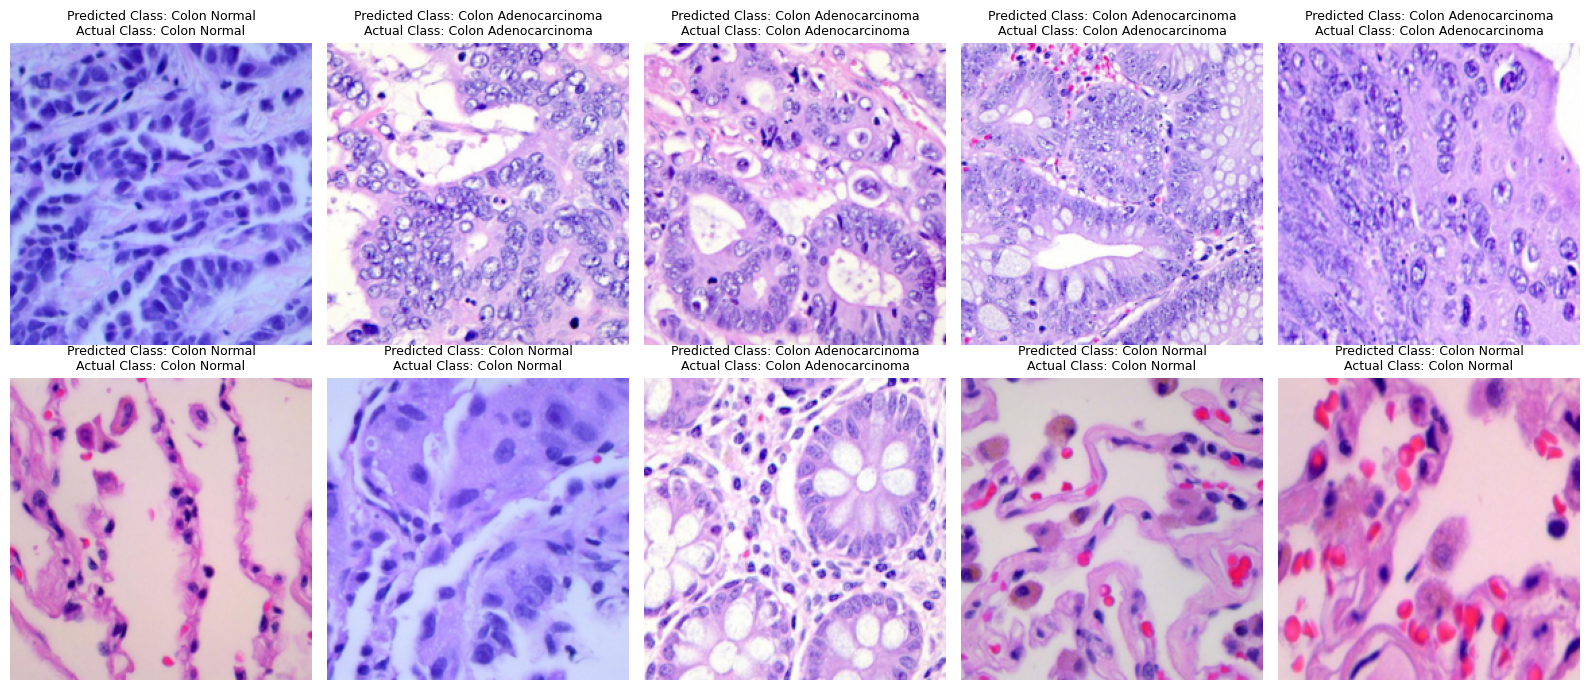

In [9]:
import matplotlib.pyplot as plt
import random

# Define your readable class names (order must match the folders/classes in your dataset)
class_names = [
    "Colon Adenocarcinoma",    # 0
    "Colon Normal",            # 1
    "Lung Adenocarcinoma",     # 2
    "Lung Normal",             # 3
    "Lung Squamous Cell Carcinoma"  # 4
]

# Make sure the global model is in evaluation mode and on CPU for inference
global_model.eval()
global_model.to('cpu')

# Randomly pick 10 unique indices from the test set
indices = random.sample(range(len(test_dataset)), 10)

# Create a 2x5 grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

for ax, idx in zip(axes.flat, indices):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = global_model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_label = pred.item()

    # Unnormalize and show image
    img = image.permute(1, 2, 0).numpy()
    # img = np.clip(img, 0, 1)  # Only needed if you did normalization (not done here)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f"Predicted Class: {class_names[predicted_label]}\nActual Class: {class_names[label]}",
        fontsize=9
    )

plt.tight_layout()
plt.show()
